# Lineární regrese aplikovaná na cenu emisní povolenky
emisní povolenka je cena kterou musejí firmy evropské unii zaplatit za každou tunu CO2 kterou vypustí do ovzduší. Nápad za touto prací je, že pokud bude například více svítit slunce/více foukat vítr, bude vyšší produkce čisté energie kterou budou firmy moci používat. Samozřejmě to tak jedoduché samozřejmě není, ale za krátké zkoumání to jednoznačně stojí

In [1]:
import pandas as pd

načteme data z : https://www.ecad.eu/dailydata/predefinedseries.php. Data obsahují čísla mezi 0-10 podle toho jak moc bylo větrno/zamračeno pro spoustu různých meteorologických stanic po celé evropě. Data začínají 1.1.2020 a končí 30.6.2024. Sloupce obsahují CC/FG - průměrná zamračenost/větrno zprůměrováno přes všechny meteorologické stanice. Dále máme sloupce s moving average, které obsahují 7 denní klouzavý průměr

In [2]:
columns_wind = ["DATE","FG","moving_average_FG"]
columns_cloud = ["DATE","CC","moving_average_CC"]

cloud = pd.read_csv("CC_ma.csv", names=columns_cloud)
wind = pd.read_csv("FG_ma.csv", names=columns_wind)

cloud['DATE'] = cloud['DATE'].astype(str)
wind['DATE'] = wind['DATE'].astype(str)

načteme data ceny energetické povolenky z : https://www.investing.com/commodities/carbon-emissions-historical-data. Data začínají 1.1.2020 a končí 30.6.2024. Tento časový úsek je zvolen proto, že v tomto úseku se událo spoustu anomálií na energetické trhu, kde se cena pohybuje mezi 20-90 euro

In [3]:
columns_price = ["date", "price"]

#prices = pd.read_csv('price.csv', names=columns_price)
prices = pd.read_csv('price.csv')

prices['date'] = prices['date'].astype(str)
#prices['price'] = prices['price'].astype(float)

pro použití lineární regrese na předpověď náhodné proměnné je vhodné aby naše předpovídaná hodnota měla normální rozdělení, pojďme tento předpoklad ověřit

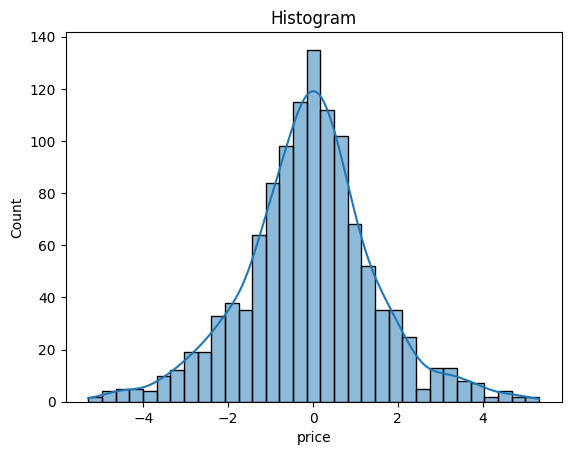

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

data = prices['price'].diff().dropna()

#odebereme outliery více jak 3 směrodatné odchylky od průměru
data = data[(np.abs(stats.zscore(data)) < 3)]

sns.histplot(data, kde=True)
plt.title('Histogram')
plt.show()

toto vypadá velmi podobně normální distribuci, můžeme pro další ověření použít například Q-Q plot který poravná kvantily dvou distribucí, čím víc jsou si distribuce podobné, tím lepší aproximaci funkce indetity bychom měli dostat

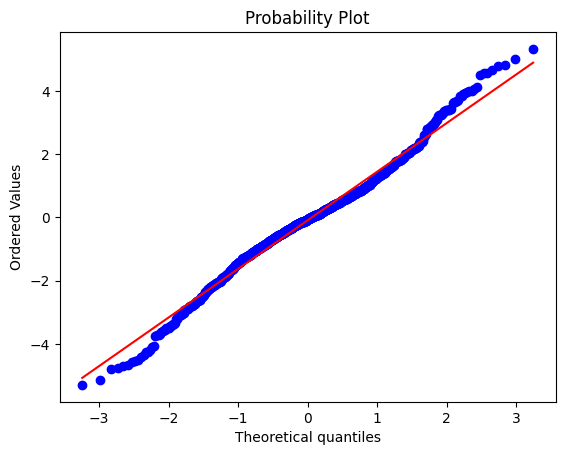

In [5]:
stats.probplot(data, dist="norm", plot=plt)
plt.show()

zkusme první jednoduchý model za pomocí pouze větrnosti a zataženosti

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

from typing import Tuple, Union

merged_df = pd.merge(cloud, wind, on='DATE')
merged_df = pd.merge(merged_df, prices, left_on='DATE', right_on='date')

merged_df['price_diff'] = merged_df['price'].diff().fillna(0)

models = {
    "lr": LinearRegression(),
    "lasso": Lasso(alpha=1),
    "ridge": Ridge(alpha=1),
}

def PrepareData(merged_pd: pd.DataFrame) -> Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    columns_to_drop = ['price', 'price_diff', 'DATE', 'date', 'date_x', 'date_y']
    #X = merged_df.drop(columns=['price', 'price_diff', 'DATE'])
    X = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])
    y = merged_df['price_diff']

    X = X.fillna(0)
    
    split_date = int(len(X) * 0.8)
    
    #nepoužívám train/test split jelikož jde o data zachycující časovou řadu 
    X_train = X[:split_date]
    X_test = X[split_date:]
    
    y_train = y[:split_date]
    y_test = y[split_date:]

    return (X_train, y_train, X_test, y_test)

def TestModel(merged_pd: pd.DataFrame, model:str = "lr") -> Union[Lasso, Ridge, LinearRegression]:
    X_train, y_train, X_test, y_test = PrepareData(merged_df)

    model = models[model]
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f'R^2: {r2_score(y_test, y_pred)}')
    print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')

    return model

TestModel(merged_df)

R^2: -0.03813418598720575
RMSE: 8.387146230690417


LinearRegression()

In [7]:
merged_df['price_lag_1'] = merged_df['price_diff'].shift(1)
merged_df['price_lag_2'] = merged_df['price_diff'].shift(2)
merged_df['price_lag_3'] = merged_df['price_diff'].shift(3)
merged_df['price_lag_4'] = merged_df['price_diff'].shift(4)
merged_df['price_lag_5'] = merged_df['price_diff'].shift(5)
merged_df['price_lag_6'] = merged_df['price_diff'].shift(6)
merged_df['price_lag_7'] = merged_df['price_diff'].shift(7)

merged_df['price_lag_20'] = merged_df['price_diff'].shift(20)
merged_df['price_lag_50'] = merged_df['price_diff'].shift(50)

merged_df['price_lag_ma_50'] = merged_df['price_lag_1'].rolling(window=50).mean()

merged_df = merged_df.fillna(0)

TestModel(merged_df)
TestModel(merged_df, "lasso")
TestModel(merged_df, "ridge")

R^2: 0.09942563283669992
RMSE: 7.811730635226106
R^2: 0.2282187394435483
RMSE: 7.2316031186764
R^2: 0.1161764372373496
RMSE: 7.738740012825325


Ridge(alpha=1)

přidáme další featury které by mohli pomoci při předpovědi

In [8]:
oil_prices = pd.read_csv('oil.csv')

oil_prices['date'] = oil_prices['date'].astype(str)

temperatures = pd.read_csv('TG_ma.csv')

temperatures['DATE'] = temperatures['DATE'].astype(str)

merged_df = pd.merge(merged_df, oil_prices, left_on='DATE', right_on='date')
merged_df = pd.merge(merged_df, temperatures, left_on='DATE', right_on='DATE')

lr = TestModel(merged_df)
lasso = TestModel(merged_df, "lasso")
ridge = TestModel(merged_df, "ridge")

R^2: 0.12563731300143932
RMSE: 7.842873520998124
R^2: 0.22790239019990688
RMSE: 7.369966390759162
R^2: 0.14281790090357194
RMSE: 7.7654378784265985


In [9]:

def print_significance(merged_df:pd.DataFrame , model:Union[Lasso, Ridge, LinearRegression]) -> None:
    X = merged_df.drop(columns=['price', 'price_diff', 'DATE', 'date_x', 'date_y'])
    
    coefficients = pd.Series(lr.coef_, index=X.columns)
    
    significant_stations = coefficients[coefficients.abs() > 0].sort_values(ascending=False)
    
    print("Top stations affecting price:")
    print(significant_stations.head(10))

for model in [lr, lasso, ridge]:
    print_significance(merged_df, model)

Top stations affecting price:
moving_average_FG    0.558237
CC                   0.395243
TG                   0.276036
TG_lag_6             0.213747
TG_lag_2             0.075283
TG_lag_4             0.066570
TG_lag_1             0.011327
val                  0.003112
price_lag_20        -0.016529
TG_lag_3            -0.059004
dtype: float64
Top stations affecting price:
moving_average_FG    0.558237
CC                   0.395243
TG                   0.276036
TG_lag_6             0.213747
TG_lag_2             0.075283
TG_lag_4             0.066570
TG_lag_1             0.011327
val                  0.003112
price_lag_20        -0.016529
TG_lag_3            -0.059004
dtype: float64
Top stations affecting price:
moving_average_FG    0.558237
CC                   0.395243
TG                   0.276036
TG_lag_6             0.213747
TG_lag_2             0.075283
TG_lag_4             0.066570
TG_lag_1             0.011327
val                  0.003112
price_lag_20        -0.016529
TG_lag_3  

In [10]:
X = merged_df.drop(columns=['price', 'price_diff', 'DATE', 'date_x', 'date_y'])
X = X.fillna(0)
y = merged_df['price_diff']

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(lasso, X, y, cv=tscv, scoring='r2')

for i, score in enumerate(scores):
    print(f'Fold {i+1}: {score}')

Fold 1: 0.018898707239632495
Fold 2: 0.37986995645634014
Fold 3: 0.3452268898698976
Fold 4: 0.43944053484227963
Fold 5: 0.09846869535438463


při cross validaci jsme se dostali ve všech pokusech s R^2 nad 0, tedy náš model je lepší než pouhé hádání průměru a můžeme předpokládat, že model umí alespoň trochu generalizovat

In [11]:
correlations = merged_df.corr()['price_diff'].sort_values(ascending=False)
print(correlations)

price_diff           1.000000
price                0.208015
price_lag_5          0.077077
moving_average_CC    0.047552
TG_lag_7             0.039207
TG_lag_6             0.030454
CC                   0.016833
TG_lag_5             0.012704
TG_lag_4             0.000605
moving_average_FG   -0.002666
TG_lag_3            -0.010092
FG                  -0.013294
date_y              -0.013366
DATE                -0.013366
date_x              -0.013366
TG_lag_2            -0.015533
val                 -0.015991
TG_lag_1            -0.018905
price_lag_20        -0.025383
TG                  -0.025500
price_lag_4         -0.026342
price_lag_50        -0.040377
price_lag_2         -0.057215
price_lag_3         -0.099602
price_lag_7         -0.140500
moving_average      -0.162086
price_lag_6         -0.178817
price_lag_1         -0.348914
price_lag_ma_50     -0.420544
Name: price_diff, dtype: float64


můžeme vidět že korelace odpovídají cca tomu, co bychom mohli očekávat. Například proměnné TG značící teplotu můžeme vidět s negativní korelací, tím se model naučil, že čím větší je průměrná teplota, tím nižší bude změna ceny povolenky

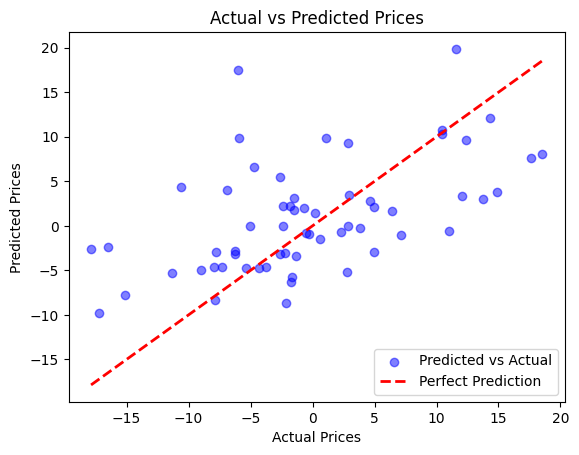

In [12]:
X_train, y_train, X_test, y_test = PrepareData(merged_df)

y_pred = lasso.predict(X_test)

plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')

plt.legend()
plt.show()

dosáhli jsme modeli který zdaleka není dokonalý a očividně se mu daří nejlépe když denní změna ceny je kolem 0. Při cross validaci jsme dostali všechny R^2 skore nad 0, tedy jsme lepší než pouhé předpovídání průměru. Zkusme zda by nám náš model mohl lehce přivydělat na důchod

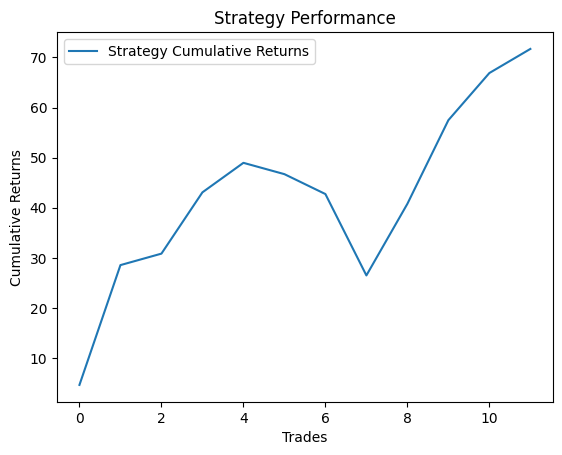

In [31]:
split_date = int(len(X) * 0.8)

backtest_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Price': merged_df[split_date:]["price"]
})

# budeme nakupovat pokud je predikovaná cesta vyšší než ta reálná
backtest_df['Signal'] = np.where(backtest_df['Predicted'] > backtest_df['Actual'], 1, 0)

#pokud je predikovaná cenna nižší než aktuální, prodáme
backtest_df['Signal'] = np.where(backtest_df['Predicted'] < backtest_df['Actual'], -1, backtest_df['Signal'])

in_position = False
entry_price = 0
strategy_returns = []

for index, row in backtest_df.iterrows():
    if row['Signal'] == 1 and not in_position:
        entry_price = row['Price']
        in_position = True
    elif row['Signal'] == -1 and in_position:
        exit_price = row['Price']
        trade_return = exit_price - entry_price
        strategy_returns.append(trade_return)
        in_position = False

cumulative_returns = np.cumsum(strategy_returns)

plt.plot(cumulative_returns, label='Strategy Cumulative Returns')
plt.title('Strategy Performance')
plt.xlabel('Trades')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()



náš model by nám nakonec při obchodování na testovací množině vydělalo nějaké peníze. Pro reálné nasezení to pravděpodobně není ale jako základ pro jednoduchou stratigii může tento model posloužit